# UCF-Crime Anomaly Detection with Multi-Task Learning

This Jupyter Notebook implements a Multi-Task Learning (MTL) pipeline for anomaly detection using an image-based UCF-Crime dataset. The pipeline processes `.png` images, trains a model with four tasks (general anomaly detection, violence detection, property crime detection, anomaly type classification), analyzes task relationships, and conducts an ablation study. The dataset is assumed to be at `/home/user/ucf_crime_dataset` with generated annotation files.

## Setup Instructions
1. Install dependencies: `pip install tensorflow opencv-python numpy pandas scikit-learn scipy`
2. Download the Kaggle dataset: https://www.kaggle.com/datasets/mission-ai/crimeucfdataset
3. Extract `.png` images or use `extract_frames.py` to convert videos to images.
4. Update paths in cells as needed (e.g., `data_dir`).
5. Run cells sequentially, inspecting outputs for debugging.


# Step 1

In [1]:
# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
import numpy as np
import os
import cv2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from scipy.stats import pearsonr
import csv
import time



In [2]:
# Define constants
DATA_DIR = 'D:/Users/eniang.eniang/Desktop/Multi-task learning/data/'  # Update to your dataset path
TRAIN_ANNOTATION_FILE = 'train_annotations.txt'
TEST_ANNOTATION_FILE = 'test_annotations.txt'
IMAGE_SIZE = (224, 224)  # Image size for ResNet50
BATCH_SIZE = 16
EPOCHS = 1
NUM_ANOMALY_TYPES = 14  # 13 anomaly classes + Normal

# Verify dataset directory
if not os.path.exists(DATA_DIR):
    raise ValueError(f"Dataset directory {DATA_DIR} does not exist. Update DATA_DIR.")

# check train and test directories
train_dir = os.path.join(DATA_DIR, "Train")
test_dir = os.path.join(DATA_DIR, "Test")

print("Train subfolders: ", os.listdir(train_dir) if os.path.exists(train_dir) else "Not found")
print("Test subfolders: ", os.listdir(test_dir) if os.path.exists(test_dir) else "Not found")

print("Setup complete. Dataset directory:", DATA_DIR)



Train subfolders:  ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Test subfolders:  ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Setup complete. Dataset directory: D:/Users/eniang.eniang/Desktop/Multi-task learning/data/


# Stage 2: Annotation Generation
Generate annotation files (train_annotations.txt, test_annotations.txt) for the image-based dataset, mapping .png images to class labels based on folder structure.



In [3]:
import glob

def generate_annotation_file(dataset_root, split, output_file):
    """
    Generate an annotation file for a given dataset split (train or test) with .png images.
    """
    split_dir = os.path.join(dataset_root, split)
    if not os.path.exists(split_dir):
        raise ValueError(f"Directory {split_dir} does not exist.")
    
    annotations = []
    class_counts = {}

    # List the class subfolders
    class_names = [name for name in os.listdir(split_dir) if os.path.isdir(os.path.join(split_dir, name))]
    print(f"Found {len(class_names)} class subfolders in {split_dir}: {class_names}")

    for class_name in class_names:
        class_dir = os.path.join(split_dir, class_name)

        # Find the images with multiple extensions
        image_files = []
        for ext in ["*.jpg", "*.PNG", "*.png", "*.JPG"]:
            image_files.extend(glob.glob(os.path.join(class_dir, ext)))

        class_counts[class_name] = len(image_files)

        for image_path in image_files:
            # construct relative path
            relative_path = os.path.join(split, class_name, os.path.basename(image_path))
            # Quote path to handle spaces
            annotation = f'"{relative_path}" {class_name}'
            annotations.append(annotation)

    # Write the annotations
    with open(output_file, "w") as f:
        for annotation in annotations:
            f.write(annotation + '\n')
    
    # debugging output
    print(f"Generated {output_file} with {len(annotations)} entries")
    print(f"Images per class in {split}:", class_counts)
    if annotations:
        print("Sample annotations (first 5):", annotations[:5])
    if not annotations:
        print("WARNING!!! no images found")
    
    return class_counts


# Generate Annotations
print("Generating training annotations..........")
train_class_counts = generate_annotation_file(DATA_DIR, "Train", TRAIN_ANNOTATION_FILE)
print("Generating test annotations..............")
test_class_counts = generate_annotation_file(DATA_DIR, "Test", TEST_ANNOTATION_FILE)

# verify annotation files
if os.path.exists(TRAIN_ANNOTATION_FILE) and os.path.exists(TEST_ANNOTATION_FILE):
    print("\nAnnotation files created successfully.")
    print("First 5 lines of the train_annotation.txt:")
    with open(TRAIN_ANNOTATION_FILE, 'r') as f:
        print(f.readlines()[:5])

else:
    raise FileNotFoundError("Annotation file not found. Check generation process")

Generating training annotations..........
Found 14 class subfolders in D:/Users/eniang.eniang/Desktop/Multi-task learning/data/Train: ['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion', 'Fighting', 'NormalVideos', 'RoadAccidents', 'Robbery', 'Shooting', 'Shoplifting', 'Stealing', 'Vandalism']
Generated train_annotations.txt with 2532690 entries
Images per class in Train: {'Abuse': 38152, 'Arrest': 52794, 'Arson': 48842, 'Assault': 20720, 'Burglary': 79008, 'Explosion': 37506, 'Fighting': 49368, 'NormalVideos': 1895536, 'RoadAccidents': 46972, 'Robbery': 82986, 'Shooting': 14280, 'Shoplifting': 49670, 'Stealing': 89604, 'Vandalism': 27252}
Sample annotations (first 5): ['"Train\\Abuse\\Abuse001_x264_0.png" Abuse', '"Train\\Abuse\\Abuse001_x264_10.png" Abuse', '"Train\\Abuse\\Abuse001_x264_100.png" Abuse', '"Train\\Abuse\\Abuse001_x264_1000.png" Abuse', '"Train\\Abuse\\Abuse001_x264_1010.png" Abuse']
Generating test annotations..............
Found 14 class subfolders in D:/U

# Stage 3: Data Loading
Load .png images and labels from the annotation files using load_ucf_crime_data. Outputs the number of loaded images and label shapes for debugging.



In [4]:

def load_ucf_crime_data(data_dir, annotation_file, image_size=(224, 224), batch_size=16, max_images=None, return_numpy=False):
    start_time = time.time()
    
    if not os.path.exists(annotation_file):
        raise FileNotFoundError(f"Annotation file {annotation_file} not found.")
    
    try:
        annotations = pd.read_csv(annotation_file, sep=' ', header=None, names=['image', 'label'], 
                                 quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
        print(f"Loaded annotation file: {annotation_file}")
        print(f"Total annotations: {len(annotations)}")
    except pd.errors.ParserError as e:
        print(f"Error parsing {annotation_file}: {e}")
        raise
    
    if len(annotations) == 0:
        raise ValueError(f"Annotation file {annotation_file} is empty.")
    
    if max_images is not None and len(annotations) > max_images:
        annotations = annotations.sample(n=max_images, random_state=42)
        print(f"Subsampled to {max_images} images")
    
    anomaly_classes = tf.constant(['Abuse', 'Arrest', 'Arson', 'Assault', 'Burglary', 'Explosion',
                                  'Fighting', 'Robbery', 'Shooting', 'Stealing', 'Shoplifting',
                                  'Vandalism', 'RoadAccident'], dtype=tf.string)
    violent_classes = tf.constant(['Assault', 'Fighting', 'Shooting'], dtype=tf.string)
    property_classes = tf.constant(['Burglary', 'Stealing', 'Shoplifting', 'Vandalism'], dtype=tf.string)
    
    @tf.function
    def process_path(image_path, label):
        try:
            img = tf.io.read_file(image_path)
            img = tf.image.decode_png(img, channels=3)
            img = tf.image.resize(img, image_size)
            img = img / 255.0
            img = tf.cast(img, tf.float32)
        except tf.errors.InvalidArgumentError:
            tf.print("Failed to decode image:", image_path)
            return tf.zeros((image_size[0], image_size[1], 3), dtype=tf.float32), {
                'general_anomaly': tf.zeros((1,), dtype=tf.int32),
                'violence': tf.zeros((1,), dtype=tf.int32),
                'property_crime': tf.zeros((1,), dtype=tf.int32),
                'anomaly_type': tf.constant(len(anomaly_classes), dtype=tf.int32)
            }
        
        is_anomaly = tf.reduce_any(tf.equal(anomaly_classes, label))
        is_anomaly = tf.cast(is_anomaly, tf.int32)
        is_anomaly = tf.expand_dims(is_anomaly, axis=-1)
        
        is_violent = tf.reduce_any(tf.equal(violent_classes, label))
        is_violent = tf.cast(is_violent, tf.int32)
        is_violent = tf.expand_dims(is_violent, axis=-1)
        
        is_property = tf.reduce_any(tf.equal(property_classes, label))
        is_property = tf.cast(is_property, tf.int32)
        is_property = tf.expand_dims(is_property, axis=-1)
        
        matches = tf.equal(anomaly_classes, label)
        indices = tf.cast(tf.where(matches), tf.int32)
        anomaly_type = tf.cond(
            tf.reduce_any(matches),
            lambda: tf.reduce_max(indices),
            lambda: tf.constant(len(anomaly_classes), dtype=tf.int32)
        )
        
        return img, {
            'general_anomaly': is_anomaly,
            'violence': is_violent,
            'property_crime': is_property,
            'anomaly_type': anomaly_type
        }
    
    image_paths = [os.path.normpath(os.path.join(data_dir, row['image'])) for _, row in annotations.iterrows()]
    labels = annotations['label'].tolist()
    
    valid_indices = [i for i, path in enumerate(image_paths) if os.path.exists(path)]
    if len(valid_indices) < len(image_paths):
        print(f"WARNING: {len(image_paths) - len(valid_indices)} invalid image paths found")
    
    image_paths = [image_paths[i] for i in valid_indices]
    labels = [labels[i] for i in valid_indices]
    print(f"Valid images: {len(image_paths)}")
    
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    
    print(f"Dataset spec before map: {dataset.element_spec}")
    
    dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
    
    print(f"Dataset spec after map: {dataset.element_spec}")
    
    pre_filter_count = len(image_paths)
    print(f"Images before filtering: {pre_filter_count}")
    
    dataset = dataset.filter(lambda img, lbl: tf.reduce_any(tf.greater(img, 0)))
    
    print(f"Dataset spec after filter: {dataset.element_spec}")
    
    try:
        post_filter_count = sum(1 for _ in dataset)
    except Exception as e:
        print(f"Warning: Failed to count post-filter images: {e}")
        post_filter_count = pre_filter_count
    print(f"Images after filtering: {post_filter_count}")
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    for images, labels in dataset.take(1):
        print(f"Batch image shape: {images.shape}")
        print(f"Batch label shapes: {{ {', '.join(f'{task}: {labels[task].shape}' for task in labels)} }}")
        print(f"Sample anomaly_type values: {labels['anomaly_type'][:5].numpy()}")
    
    expected_steps = (post_filter_count + batch_size - 1) // batch_size
    print(f"Expected steps per epoch: {expected_steps} (with batch_size={batch_size})")
    
    if not return_numpy:
        print(f"Returning tf.data.Dataset for {annotation_file}")
        print(f"Time taken: {time.time() - start_time:.2f} seconds")
        return dataset
    
    images = []
    label_dict = {
        'general_anomaly': [],
        'violence': [],
        'property_crime': [],
        'anomaly_type': []
    }
    
    for img, lbl in dataset.unbatch():
        images.append(img.numpy())
        for task in label_dict:
            label_dict[task].append(lbl[task].numpy())
    
    images = np.array(images)
    for task in label_dict:
        label_dict[task] = np.array(label_dict[task])
    
    print(f"Returning NumPy arrays: images shape {images.shape}, label shapes {{ {', '.join(f'{task}: {label_dict[task].shape}' for task in label_dict)} }}")
    print(f"Time taken: {time.time() - start_time:.2f} seconds")
    return images, label_dict

print("Loading training data...")
try:
    train_dataset = load_ucf_crime_data(DATA_DIR, TRAIN_ANNOTATION_FILE, IMAGE_SIZE, BATCH_SIZE, max_images=10000, return_numpy=False)
except Exception as e:
    print(f"Failed to load training data: {e}")
    raise

print("\nLoading validation data...")
try:
    val_dataset = load_ucf_crime_data(DATA_DIR, TEST_ANNOTATION_FILE, IMAGE_SIZE, BATCH_SIZE, max_images=2000, return_numpy=False)
except Exception as e:
    print(f"Failed to load validation data: {e}")
    raise

print("\nDatasets ready for training")

Loading training data...
Loaded annotation file: train_annotations.txt
Total annotations: 2532690
Subsampled to 10000 images
Valid images: 10000
Dataset spec before map: (TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None))
Dataset spec after map: (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), {'general_anomaly': TensorSpec(shape=(1,), dtype=tf.int32, name=None), 'violence': TensorSpec(shape=(1,), dtype=tf.int32, name=None), 'property_crime': TensorSpec(shape=(1,), dtype=tf.int32, name=None), 'anomaly_type': TensorSpec(shape=(), dtype=tf.int32, name=None)})
Images before filtering: 10000
Dataset spec after filter: (TensorSpec(shape=(224, 224, 3), dtype=tf.float32, name=None), {'general_anomaly': TensorSpec(shape=(1,), dtype=tf.int32, name=None), 'violence': TensorSpec(shape=(1,), dtype=tf.int32, name=None), 'property_crime': TensorSpec(shape=(1,), dtype=tf.int32, name=None), 'anomaly_type': TensorSpec(shape=(), dtype=tf.int

# Stage 4: Model Definition
Define the MTL model with a ResNet50 backbone and four task-specific heads using build_mtl_model. Display the model summary for inspection.



In [5]:
def build_mtl_model(input_shape=(224, 224, 3), num_anomaly_types=14):
    """
    Build MTL model with shared ResNet50 backbone and task-specific heads for images.
    """
    inputs = tf.keras.Input(shape=input_shape)
    
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    x = base_model(inputs)
    pooled = layers.GlobalAveragePooling2D()(x)
    shared_dense = layers.Dense(512, activation='relu')(pooled)
    
    anomaly_output = layers.Dense(1, activation='sigmoid', name='general_anomaly')(shared_dense)
    violence_output = layers.Dense(1, activation='sigmoid', name='violence')(shared_dense)
    property_output = layers.Dense(1, activation='sigmoid', name='property_crime')(shared_dense)
    type_output = layers.Dense(num_anomaly_types, activation='softmax', name='anomaly_type')(shared_dense)
    
    model = models.Model(inputs, [
        anomaly_output, violence_output, property_output, type_output
    ])
    
    return model


# Build model and display summary
model = build_mtl_model(input_shape=(224, 224, 3), num_anomaly_types=NUM_ANOMALY_TYPES)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet50 (Functional)          (None, 7, 7, 2048)   23587712    ['input_1[0][0]']                
                                                                                                  
 global_average_pooling2d (Glob  (None, 2048)        0           ['resnet50[0][0]']               
 alAveragePooling2D)                                                                              
                                                                                              

# Stage 5: Task Relationship Functions
Define functions to analyze task relationships: compute_gradient_alignment (cosine similarity of gradients) and compute_loss_correlation (Pearson correlation of losses).



In [6]:
# Stage 5 or Helper: Gradient Alignment

def compute_gradient_alignment(model, data, labels, task_names):
    """
    Compute cosine similarity between gradients of different tasks.
    
    Args:
        model: Keras MTL model.
        data: Input data batch (e.g., shape (batch_size, 224, 224, 3)).
        labels: Dict of label tensors (e.g., {'general_anomaly': (batch_size, 1), ..., 'anomaly_type': (batch_size,)}).
        task_names: List of task names ['general_anomaly', 'violence', 'property_crime', 'anomaly_type'].
    
    Returns:
        Dict of task pair similarities (cosine similarity of gradients).
    """
    gradients = {}
    loss_functions = {
        'general_anomaly': tf.keras.losses.BinaryCrossentropy(),
        'violence': tf.keras.losses.BinaryCrossentropy(),
        'property_crime': tf.keras.losses.BinaryCrossentropy(),
        'anomaly_type': tf.keras.losses.SparseCategoricalCrossentropy()
    }
    
    # Debug input shapes
    print(f"Input data shape: {data.shape}")
    print(f"Label shapes: {{ {', '.join(f'{task}: {labels[task].shape}' for task in task_names)} }}")
    
    # Get trainable variables (task-specific dense layers)
    trainable_vars = [v for v in model.trainable_variables if 'dense' in v.name]
    print(f"Trainable variables: {[v.name for v in trainable_vars]}")
    
    for task in task_names:
        with tf.GradientTape() as tape:
            predictions = model(data)
            task_idx = task_names.index(task)
            loss = loss_functions[task](labels[task], predictions[task_idx])
            grads = tape.gradient(loss, trainable_vars)
            # Debug gradient shapes
            grad_shapes = [g.shape.as_list() if g is not None else None for g in grads]
            print(f"Task {task} gradient shapes: {grad_shapes}")
            gradients[task] = grads
    
    similarities = {}
    for i, task1 in enumerate(task_names):
        for task2 in task_names[i+1:]:
            grads1 = [g for g in gradients[task1] if g is not None]
            grads2 = [g for g in gradients[task2] if g is not None]
            if not grads1 or not grads2:
                print(f"Skipping {task1}_{task2}: No valid gradients")
                similarities[f"{task1}_{task2}"] = 0.0
                continue
            # Flatten gradients
            flat_grads1 = tf.concat([tf.reshape(g, [-1]) for g in grads1], axis=0)
            flat_grads2 = tf.concat([tf.reshape(g, [-1]) for g in grads2], axis=0)
            # Verify shapes
            if flat_grads1.shape != flat_grads2.shape:
                print(f"Shape mismatch for {task1}_{task2}: {flat_grads1.shape} vs {flat_grads2.shape}")
                similarities[f"{task1}_{task2}"] = 0.0
                continue
            cosine_sim = tf.reduce_sum(flat_grads1 * flat_grads2) / (
                tf.sqrt(tf.reduce_sum(tf.square(flat_grads1))) * tf.sqrt(tf.reduce_sum(tf.square(flat_grads2))) + 1e-10
            )
            similarities[f"{task1}_{task2}"] = cosine_sim.numpy()
    
    return similarities

from scipy.stats import pearsonr

def compute_loss_correlation(losses_dict, task_names):
    """
    Compute Pearson correlation between task losses.
    
    Args:
        losses_dict: Dict of loss lists per task (e.g., {'general_anomaly': [0.5, 0.4, ...], ...}).
        task_names: List of task names.
    
    Returns:
        Dict of correlations between task pairs.
    """
    correlations = {}
    for task1 in task_names:
        for task2 in task_names:
            if task1 >= task2:
                continue
            if len(losses_dict[task1]) < 2 or len(losses_dict[task2]) < 2:
                print(f"Skipping correlation for {task1}_vs_{task2}: insufficient loss values ({len(losses_dict[task1])}, {len(losses_dict[task2])})")
                correlations[f'{task1}_vs_{task2}'] = 0.0
                continue
            corr, _ = pearsonr(losses_dict[task1], losses_dict[task2])
            correlations[f'{task1}_vs_{task2}'] = corr
    print("Computed loss correlations:", correlations)
    return correlations



# Stage 6: Training Function
Define train_mtl_model to train the MTL model, compute task relationships, and return training history. Monitor training progress via printed outputs.



In [7]:
import tensorflow as tf
import psutil

def train_mtl_model(model, train_data, train_labels, val_data, val_labels, epochs=10, batch_size=16):
    task_names = ['general_anomaly', 'violence', 'property_crime', 'anomaly_type']
    losses_dict = {task: [] for task in task_names}
    
    model.compile(
        optimizer='adam',
        loss={
            'general_anomaly': tf.keras.losses.BinaryCrossentropy(),
            'violence': tf.keras.losses.BinaryCrossentropy(),
            'property_crime': tf.keras.losses.BinaryCrossentropy(),
            'anomaly_type': tf.keras.losses.SparseCategoricalCrossentropy()
        },
        loss_weights={
            'general_anomaly': 1.0,
            'violence': 0.5,
            'property_crime': 0.5,
            'anomaly_type': 1.0
        },
        metrics={
            'general_anomaly': ['accuracy', tf.keras.metrics.AUC(name='auc')],
            'violence': ['accuracy'],
            'property_crime': ['accuracy'],
            'anomaly_type': ['accuracy']
        }
    )
    
    print(f"Memory used before training: {psutil.Process().memory_info().rss / 1024**2:.2f} MB")
    
    if isinstance(train_data, tf.data.Dataset):
        train_input = train_data
        val_input = val_data
        for batch_images, _ in train_data.take(1):
            if batch_images.shape[0] != batch_size:
                raise ValueError(f"Train dataset batch size {batch_images.shape[0]} does not match {batch_size}")
        for batch_images, _ in val_data.take(1):
            if batch_images.shape[0] != batch_size:
                raise ValueError(f"Validation dataset batch size {batch_images.shape[0]} does not match {batch_size}")
        train_cardinality = sum(1 for _ in train_data)
        print(f"Train dataset cardinality: {train_cardinality} batches")
        print(f"Expected steps per epoch: {train_cardinality}")
    else:
        train_input = train_data
        val_input = val_data
        train_labels = [train_labels[task] for task in task_names]
        val_labels = [val_labels[task] for task in task_names]
    
    history = model.fit(
        train_input,
        validation_data=val_input,
        epochs=epochs,
        batch_size=batch_size if isinstance(train_input, np.ndarray) else None,
        verbose=1
    )
    
    for task in task_names:
        losses_dict[task] = history.history[f'{task}_loss']
        print(f"Losses for {task}: {losses_dict[task]}")
    
    print(f"Memory used after training: {psutil.Process().memory_info().rss / 1024**2:.2f} MB")
    
    if isinstance(val_data, tf.data.Dataset):
        for batch_images, batch_labels in val_data.take(1):
            val_batch = batch_images
            val_labels_batch = batch_labels
            break
    else:
        val_batch = val_data[:batch_size]
        val_labels_batch = {task: val_labels[task][:batch_size] for task in task_names}
    
    print(f"Memory used before gradient alignment: {psutil.Process().memory_info().rss / 1024**2:.2f} MB")
    grad_similarities = compute_gradient_alignment(model, val_batch, val_labels_batch, task_names)
    print(f"Memory used after gradient alignment: {psutil.Process().memory_info().rss / 1024**2:.2f} MB")
    
    loss_correlations = compute_loss_correlation(losses_dict, task_names)
    
    return history, grad_similarities, loss_correlations

# Stage 7: Ablation Study
Define ablation_study to evaluate the model with subsets of tasks, reporting AUC for general anomaly detection.



In [8]:
def ablation_study(X_train, y_train, X_val, y_val, tasks_to_include, input_shape=(224, 224, 3), num_anomaly_types=14):
    """
    Train model with a subset of tasks for ablation study.
    """
    inputs = tf.keras.Input(shape=input_shape)
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    x = base_model(inputs)
    pooled = layers.GlobalAveragePooling2D()(x)
    shared_dense = layers.Dense(512, activation='relu')(pooled)
    
    outputs = []
    loss_dict = {}
    metrics_dict = {}
    
    for task in tasks_to_include:
        if task in ['general_anomaly', 'violence', 'property_crime']:
            output = layers.Dense(1, activation='sigmoid', name=task)(shared_dense)
            loss_dict[task] = 'binary_crossentropy'
            metrics_dict[task] = ['accuracy']
        elif task == 'anomaly_type':
            output = layers.Dense(num_anomaly_types, activation='softmax', name=task)(shared_dense)
            loss_dict[task] = 'sparse_categorical_crossentropy'
            metrics_dict[task] = ['accuracy']
        outputs.append(output)
    
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss=loss_dict,
        metrics=metrics_dict
    )
    
    history = model.fit(
        X_train,
        [y_train[task] for task in tasks_to_include],
        validation_data=(X_val, [y_val[task] for task in tasks_to_include]),
        epochs=1,
        batch_size=32,
        verbose=1
    )
    
    val_preds = model.predict(X_val)
    general_idx = tasks_to_include.index('general_anomaly') if 'general_anomaly' in tasks_to_include else None
    if general_idx is not None:
        auc = roc_auc_score(y_val['general_anomaly'], val_preds[general_idx])
        print(f"AUC for tasks {tasks_to_include}: {auc:.4f}")
        return auc
    return None

# Stage 8: Execution and Results
Run the pipeline, train the model, compute task relationships, and perform the ablation study. Display results for gradient alignment, loss correlation, and AUC scores.



In [9]:
import tensorflow as tf
from sklearn.metrics import roc_auc_score
import numpy as np

BATCH_SIZE = 16  # Ensure 625 steps for 10000 images
EPOCHS = 10

print("Training MTL model...")
history, grad_similarities, loss_correlations = train_mtl_model(
    model, train_dataset, None, val_dataset, None, epochs=EPOCHS, batch_size=BATCH_SIZE
)

print("\nGradient Alignment (Cosine Similarity):")
for pair, sim in grad_similarities.items():
    print(f"{pair}: {sim:.4f}")

print("\nLoss Correlation (Pearson):")
for pair, corr in loss_correlations.items():
    print(f"{pair}: {corr:.4f}")

def ablation_study(train_dataset, val_dataset, tasks_to_include, input_shape=(224, 224, 3), num_anomaly_types=14):
    # Filter dataset labels to match tasks_to_include
    def filter_labels(image, labels):
        filtered_labels = {task: labels[task] for task in tasks_to_include}
        return image, filtered_labels
    
    # Re-batch to ensure correct batch size
    filtered_train_dataset = train_dataset.map(filter_labels, num_parallel_calls=tf.data.AUTOTUNE).unbatch().batch(BATCH_SIZE)
    filtered_val_dataset = val_dataset.map(filter_labels, num_parallel_calls=tf.data.AUTOTUNE).unbatch().batch(BATCH_SIZE)
    
    # Verify filtered dataset
    for images, labels in filtered_train_dataset.take(1):
        print(f"Ablation train batch: images shape {images.shape}, labels {{ {', '.join(f'{task}: {labels[task].shape}' for task in labels)} }}")
    for images, labels in filtered_val_dataset.take(1):
        print(f"Ablation val batch: images shape {images.shape}, labels {{ {', '.join(f'{task}: {labels[task].shape}' for task in labels)} }}")
    
    inputs = tf.keras.Input(shape=input_shape)
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    x = base_model(inputs)
    pooled = tf.keras.layers.GlobalAveragePooling2D()(x)
    shared_dense = tf.keras.layers.Dense(512, activation='relu')(pooled)
    
    outputs = {}
    loss_dict = {}
    metrics_dict = {}
    
    for task in tasks_to_include:
        if task in ['general_anomaly', 'violence', 'property_crime']:
            output = tf.keras.layers.Dense(1, activation='sigmoid', name=task)(shared_dense)
            loss_dict[task] = tf.keras.losses.BinaryCrossentropy()
            metrics_dict[task] = ['accuracy']
        elif task == 'anomaly_type':
            output = tf.keras.layers.Dense(num_anomaly_types, activation='softmax', name=task)(shared_dense)
            loss_dict[task] = tf.keras.losses.SparseCategoricalCrossentropy()
            metrics_dict[task] = ['accuracy']
        outputs[task] = output
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    # Debug model output shapes
    print("Model output shapes:")
    for output_name, output_tensor in model.output.items():
        print(f"{output_name}: {output_tensor.shape}")
    
    model.compile(
        optimizer='adam',
        loss=loss_dict,
        metrics=metrics_dict
    )
    
    history = model.fit(
        filtered_train_dataset,
        validation_data=filtered_val_dataset,
        epochs=5,
        verbose=1
    )
    
    for batch_images, batch_labels in filtered_val_dataset.take(1):
        print(f"Prediction batch_images shape: {batch_images.shape}")
        val_preds = model.predict(batch_images)
        val_true = batch_labels['general_anomaly'].numpy() if 'general_anomaly' in batch_labels else None
        # Handle dict output from model.predict
        if isinstance(val_preds, dict):
            val_preds = [val_preds[task] for task in tasks_to_include]
        # Debug prediction shapes
        print(f"val_true shape: {val_true.shape if val_true is not None else None}")
        print(f"val_preds shapes: {[pred.shape for pred in val_preds]}")
        break
    
    general_idx = tasks_to_include.index('general_anomaly') if 'general_anomaly' in tasks_to_include else None
    if general_idx is not None and val_true is not None:
        # Ensure val_preds[general_idx] is flattened to match val_true
        y_score = val_preds[general_idx].flatten()
        print(f"y_score shape: {y_score.shape}")
        # Flatten val_true to 1D
        y_true = val_true.flatten()
        print(f"y_true shape: {y_true.shape}")
        auc = roc_auc_score(y_true, y_score)
        print(f"AUC for tasks {tasks_to_include}: {auc:.4f}")
        return auc
    return None

print("\nAblation Study Results (AUC for General Anomaly Detection):")
task_combinations = [
    ['general_anomaly'],
    ['general_anomaly', 'violence', 'property_crime'],
    ['general_anomaly', 'anomaly_type'],
    ['general_anomaly', 'violence', 'property_crime', 'anomaly_type']
]

for tasks in task_combinations:
    auc = ablation_study(train_dataset, val_dataset, tasks)
    if auc is not None:
        print(f"Tasks: {tasks}, AUC: {auc:.4f}")

Training MTL model...
Memory used before training: 1612.31 MB
Train dataset cardinality: 625 batches
Expected steps per epoch: 625
Epoch 1/10
625/625 [==============================] - 30s 33ms/step - loss: 1.9080 - general_anomaly_loss: 0.5455 - violence_loss: 0.1576 - property_crime_loss: 0.3220 - anomaly_type_loss: 1.1227 - general_anomaly_accuracy: 0.7654 - general_anomaly_auc: 0.5529 - violence_accuracy: 0.9640 - property_crime_accuracy: 0.9025 - anomaly_type_accuracy: 0.7640 - val_loss: 2.7441 - val_general_anomaly_loss: 0.6781 - val_violence_loss: 0.3367 - val_property_crime_loss: 0.4654 - val_anomaly_type_loss: 1.6649 - val_general_anomaly_accuracy: 0.5988 - val_general_anomaly_auc: 0.7219 - val_violence_accuracy: 0.8949 - val_property_crime_accuracy: 0.8264 - val_anomaly_type_accuracy: 0.5988
Epoch 2/10
625/625 [==============================] - 17s 28ms/step - loss: 1.8387 - general_anomaly_loss: 0.5274 - violence_loss: 0.1537 - property_crime_loss: 0.3140 - anomaly_type_loss

In [10]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import roc_auc_score

BATCH_SIZE = 16  # Ensure 625 steps for 10000 images
EPOCHS = 10

def extended_ablation_study(train_dataset, val_dataset, tasks_to_include, input_shape=(224, 224, 3), num_anomaly_types=13):
    # Filter dataset labels to match tasks_to_include
    def filter_labels(image, labels):
        filtered_labels = {task: labels[task] for task in tasks_to_include}
        return image, filtered_labels
    
    # Re-batch to ensure correct batch size
    filtered_train_dataset = train_dataset.map(filter_labels, num_parallel_calls=tf.data.AUTOTUNE).unbatch().batch(BATCH_SIZE)
    filtered_val_dataset = val_dataset.map(filter_labels, num_parallel_calls=tf.data.AUTOTUNE).unbatch().batch(BATCH_SIZE)
    
    # Verify dataset - modified NaN check for integer labels
    for images, labels in filtered_train_dataset.take(1):
        print(f"Extended ablation train batch: images shape {images.shape}, labels {{ {', '.join(f'{task}: {labels[task].shape}' for task in labels)} }}")
        print(f"Train images NaN: {tf.reduce_any(tf.math.is_nan(images))}")
        for task in labels:
            if labels[task].dtype.is_floating:
                print(f"Train {task} NaN: {tf.reduce_any(tf.math.is_nan(labels[task]))}")
            else:
                print(f"Train {task} is integer type (cannot check for NaN)")
    
    for images, labels in filtered_val_dataset.take(1):
        print(f"Extended ablation val batch: images shape {images.shape}, labels {{ {', '.join(f'{task}: {labels[task].shape}' for task in labels)} }}")
        print(f"Val images NaN: {tf.reduce_any(tf.math.is_nan(images))}")
        for task in labels:
            if labels[task].dtype.is_floating:
                print(f"Val {task} NaN: {tf.reduce_any(tf.math.is_nan(labels[task]))}")
            else:
                print(f"Val {task} is integer type (cannot check for NaN)")

    # Rest of your function remains the same...
    inputs = tf.keras.Input(shape=input_shape)
    base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False
    
    x = base_model(inputs)
    pooled = tf.keras.layers.GlobalAveragePooling2D()(x)
    shared_dense = tf.keras.layers.Dense(512, activation='relu')(pooled)
    
    outputs = {}
    loss_dict = {}
    metrics_dict = {}
    
    for task in tasks_to_include:
        if task in ['general_anomaly', 'violence', 'property_crime']:
            output = tf.keras.layers.Dense(1, activation='sigmoid', name=task)(shared_dense)
            loss_dict[task] = tf.keras.losses.BinaryCrossentropy()
            metrics_dict[task] = ['accuracy']
        elif task == 'anomaly_type':
            output = tf.keras.layers.Dense(num_anomaly_types, activation='softmax', name=task)(shared_dense)
            loss_dict[task] = tf.keras.losses.SparseCategoricalCrossentropy()
            metrics_dict[task] = ['accuracy']
        outputs[task] = output
    
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    
    # Debug model output shapes
    print("Model output shapes:")
    for output_name, output_tensor in model.output.items():
        print(f"{output_name}: {output_tensor.shape}")
    
    # Use lower learning rate and gradient clipping
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4, clipnorm=1.0)
    model.compile(
        optimizer=optimizer,
        loss=loss_dict,
        metrics=metrics_dict
    )
    
    # Debug loss during training
    history = model.fit(
        filtered_train_dataset,
        validation_data=filtered_val_dataset,
        epochs=5,
        verbose=1,
        callbacks=[
            tf.keras.callbacks.LambdaCallback(
                on_epoch_end=lambda epoch, logs: print(f"Epoch {epoch+1} losses: {', '.join(f'{task}: {logs.get(task_loss, np.nan):.4f}' for task_loss in logs if 'loss' in task_loss)}")
            )
        ]
    )
    
    # Collect predictions and true labels
    y_true_dict = {task: [] for task in tasks_to_include}
    y_score_dict = {task: [] for task in tasks_to_include}
    
    for batch_images, batch_labels in filtered_val_dataset:
        print(f"Prediction batch_images shape: {batch_images.shape}")
        val_preds = model.predict(batch_images, verbose=0)
        if isinstance(val_preds, dict):
            val_preds = {task: val_preds[task] for task in tasks_to_include}
        else:
            val_preds = {task: pred for task, pred in zip(tasks_to_include, val_preds)}
        
        # Check predictions for NaN
        for task in tasks_to_include:
            if np.any(np.isnan(val_preds[task])):
                print(f"Warning: NaN detected in predictions for {task}")
        
        for task in tasks_to_include:
            y_true_dict[task].append(batch_labels[task].numpy())
            y_score_dict[task].append(val_preds[task])
    
    # Concatenate and compute AUC
    auc_scores = {}
    for task in tasks_to_include:
        y_true = np.concatenate(y_true_dict[task], axis=0)
        y_score = np.concatenate(y_score_dict[task], axis=0)
        print(f"{task} - y_true shape: {y_true.shape}, y_score shape: {y_score.shape}")
        print(f"{task} - y_true NaN: {np.any(np.isnan(y_true))}")
        print(f"{task} - y_score NaN: {np.any(np.isnan(y_score))}")
        
        if task in ['general_anomaly', 'violence', 'property_crime']:
            # Filter NaN for binary classification
            valid_mask = ~np.isnan(y_true) & ~np.isnan(y_score)
            if np.sum(valid_mask) < 2:
                print(f"Warning: Insufficient valid samples for {task} AUC")
                auc_scores[task] = np.nan
                continue
            y_true_valid = y_true[valid_mask].flatten()
            y_score_valid = y_score[valid_mask].flatten()
            try:
                auc = roc_auc_score(y_true_valid, y_score_valid)
                auc_scores[task] = auc
            except ValueError as e:
                print(f"Warning: AUC computation failed for {task}: {e}")
                auc_scores[task] = np.nan
        elif task == 'anomaly_type':
            # Debug unique classes
            unique_classes = np.unique(y_true)
            print(f"anomaly_type unique classes: {unique_classes}")
            # Filter invalid labels (e.g., anomaly_type=13)
            valid_mask = y_true < num_anomaly_types
            if not np.any(valid_mask):
                print(f"Warning: No valid labels for anomaly_type")
                auc_scores[task] = np.nan
                continue
            y_true_filtered = y_true[valid_mask]
            y_score_filtered = y_score[valid_mask]
            valid_classes = unique_classes[unique_classes < num_anomaly_types]
            if len(valid_classes) < 2:
                print(f"Warning: Fewer than 2 classes for anomaly_type")
                auc_scores[task] = np.nan
                continue
            class_indices = [int(cls) for cls in valid_classes]
            y_score_selected = y_score_filtered[:, class_indices]
            print(f"anomaly_type filtered - y_true shape: {y_true_filtered.shape}, y_score shape: {y_score_selected.shape}")
            try:
                auc = roc_auc_score(y_true_filtered, y_score_selected, multi_class='ovr')
                auc_scores[task] = auc
            except ValueError as e:
                print(f"Warning: AUC computation failed for anomaly_type: {e}")
                auc_scores[task] = np.nan
    
    # Print AUC scores
    print(f"\nAUC Scores for tasks {tasks_to_include}:")
    for task, auc in auc_scores.items():
        print(f"- {task}: {auc:.4f}")
    
    return auc_scores

print("\nExtended Ablation Study Results (Individual AUC Scores):")
task_combinations = [
    ['general_anomaly'],
    ['general_anomaly', 'violence', 'property_crime'],
    ['general_anomaly', 'anomaly_type'],
    ['general_anomaly', 'violence', 'property_crime', 'anomaly_type']
]

all_auc_scores = []
for tasks in task_combinations:
    auc_scores = extended_ablation_study(train_dataset, val_dataset, tasks)
    all_auc_scores.append((tasks, auc_scores))

# Print summary table
print("\nSummary of AUC Scores Across Task Combinations:")
print("-" * 60)
print(f"{'Combination':<40} {'Tasks and AUCs'}")
print("-" * 60)
for tasks, auc_scores in all_auc_scores:
    task_auc_str = ', '.join(f"{task}: {auc:.4f}" for task, auc in auc_scores.items())
    print(f"{str(tasks):<40} {task_auc_str}")
print("-" * 60)


Extended Ablation Study Results (Individual AUC Scores):
Extended ablation train batch: images shape (16, 224, 224, 3), labels { general_anomaly: (16, 1) }
Train images NaN: False
Train general_anomaly is integer type (cannot check for NaN)
Extended ablation val batch: images shape (16, 224, 224, 3), labels { general_anomaly: (16, 1) }
Val images NaN: False
Val general_anomaly is integer type (cannot check for NaN)
Model output shapes:
general_anomaly: (None, 1)
Epoch 1/5
    625/Unknown - 16s 21ms/step - loss: 0.5420 - accuracy: 0.7639Epoch 1 losses: general_anomaly: 0.5420, general_anomaly: 0.6529
625/625 [==============================] - 20s 26ms/step - loss: 0.5420 - accuracy: 0.7639 - val_loss: 0.6529 - val_accuracy: 0.5988
Epoch 2/5
625/625 [==============================] - 15s 24ms/step - loss: 0.5224 - accuracy: 0.7642 - val_loss: 0.6364 - val_accuracy: 0.6048
Epoch 3/5
625/625 [==============================] - 15s 24ms/step - loss: 0.5113 - accuracy: 0.7637 - val_loss: 0.6


Evaluation for Task: general_anomaly

Classification Report:
              precision    recall  f1-score   support

      Normal       0.67      0.89      0.76      1197
     Anomaly       0.67      0.34      0.45       802

    accuracy                           0.67      1999
   macro avg       0.67      0.61      0.61      1999
weighted avg       0.67      0.67      0.64      1999



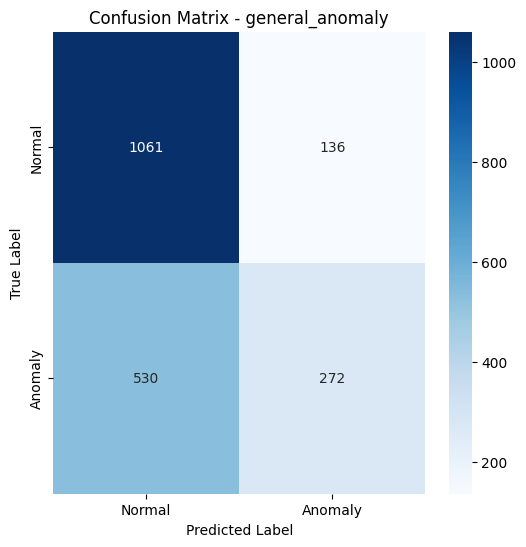

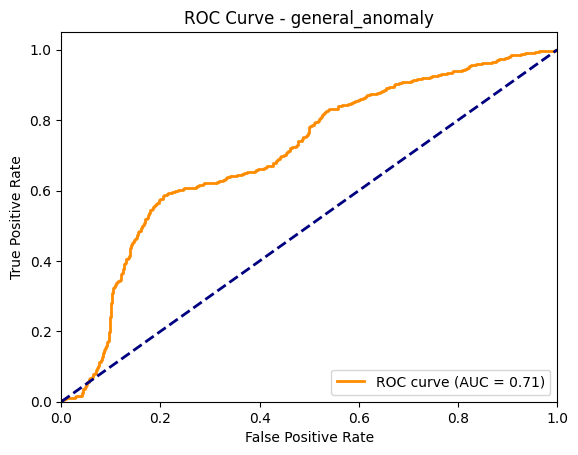


Evaluation for Task: violence

Classification Report:
              precision    recall  f1-score   support

      Normal       0.89      1.00      0.94      1789
     Anomaly       0.00      0.00      0.00       210

    accuracy                           0.89      1999
   macro avg       0.45      0.50      0.47      1999
weighted avg       0.80      0.89      0.85      1999



d:\Users\eniang.eniang\AppData\Local\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\eniang.eniang\AppData\Local\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\eniang.eniang\AppData\Local\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

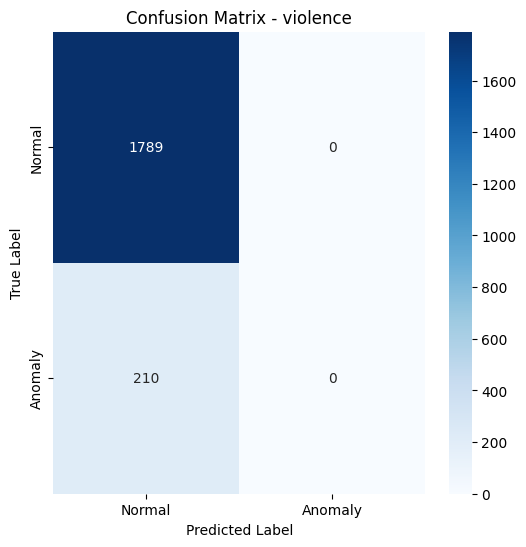

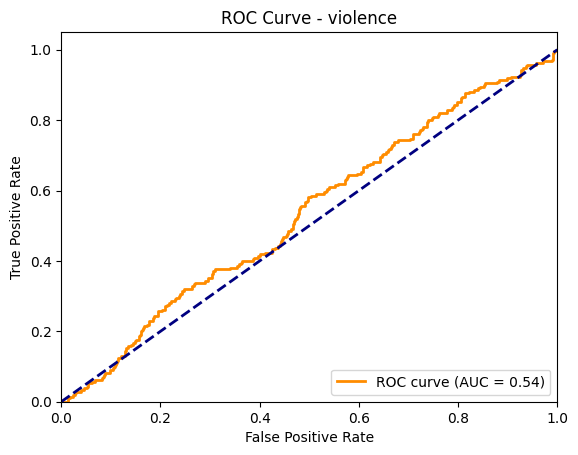


Evaluation for Task: property_crime

Classification Report:
              precision    recall  f1-score   support

      Normal       0.83      1.00      0.90      1652
     Anomaly       0.00      0.00      0.00       347

    accuracy                           0.83      1999
   macro avg       0.41      0.50      0.45      1999
weighted avg       0.68      0.83      0.75      1999



d:\Users\eniang.eniang\AppData\Local\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\eniang.eniang\AppData\Local\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\eniang.eniang\AppData\Local\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

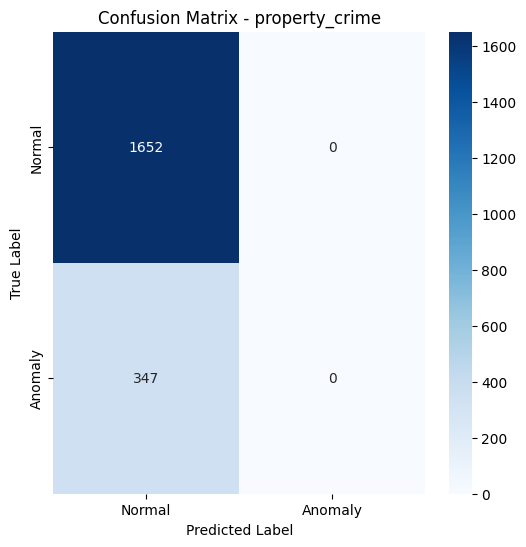

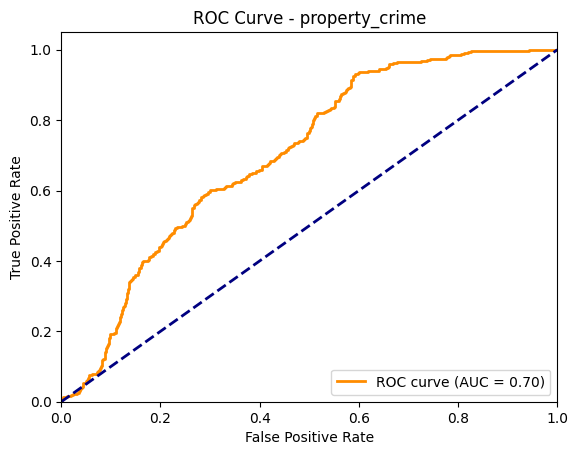


Evaluation for Task: anomaly_type

Classification Report:
              precision    recall  f1-score   support

     Class_0       0.00      0.00      0.00         2
     Class_1       0.00      0.00      0.00        61
     Class_2       0.00      0.00      0.00        57
     Class_3       0.00      0.00      0.00        48
     Class_4       0.00      0.00      0.00       151
     Class_5       0.00      0.00      0.00       105
     Class_6       0.00      0.00      0.00        18
     Class_7       0.00      0.00      0.00        20
     Class_8       0.00      0.00      0.00       144
     Class_9       0.00      0.00      0.00        42
    Class_10       0.00      0.00      0.00       119
    Class_11       0.00      0.00      0.00        35
      Normal       0.60      1.00      0.75      1197

    accuracy                           0.60      1999
   macro avg       0.05      0.08      0.06      1999
weighted avg       0.36      0.60      0.45      1999



d:\Users\eniang.eniang\AppData\Local\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\eniang.eniang\AppData\Local\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Users\eniang.eniang\AppData\Local\anaconda3\envs\tf_gpu\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

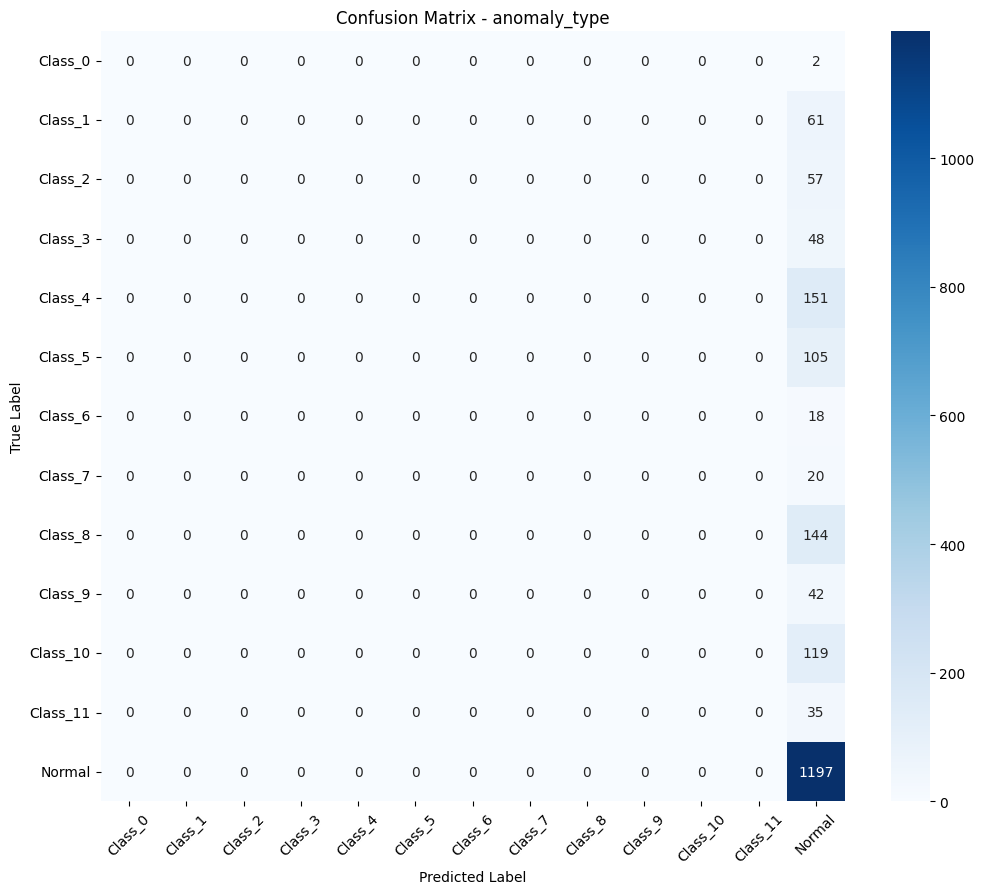

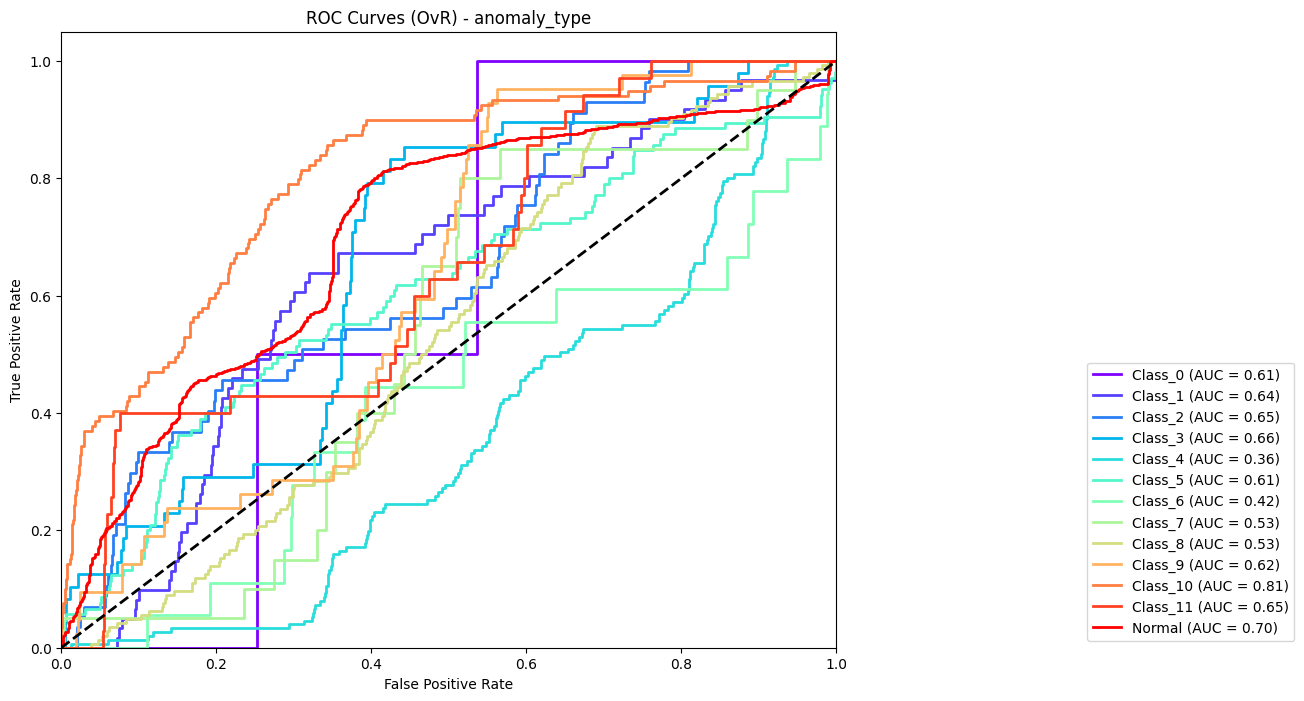

In [12]:

import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
from sklearn.preprocessing import label_binarize

def evaluate_and_plot(model, val_dataset, task_names, num_anomaly_types=13):
    """
    Generate classification reports and plots for each task in the MTL model
    
    Args:
        model: Trained multi-task learning model
        val_dataset: Validation dataset
        task_names: List of task names
        num_anomaly_types: Number of anomaly types (for anomaly_type task)
    """
    
    # Collect predictions and true labels
    y_true_dict = {task: [] for task in task_names}
    y_pred_dict = {task: [] for task in task_names}
    y_score_dict = {task: [] for task in task_names}
    
    for batch_images, batch_labels in val_dataset:
        batch_preds = model.predict(batch_images, verbose=0)
        
        # Handle both dictionary and list outputs
        if isinstance(batch_preds, dict):
            batch_preds = {task: batch_preds[task] for task in task_names}
        else:
            batch_preds = {task: batch_preds[i] for i, task in enumerate(task_names)}
        
        for task in task_names:
            y_true_dict[task].append(batch_labels[task].numpy())
            y_pred_dict[task].append(batch_preds[task])
            y_score_dict[task].append(batch_preds[task])
    
    # Concatenate results
    for task in task_names:
        y_true_dict[task] = np.concatenate(y_true_dict[task], axis=0)
        y_pred_dict[task] = np.concatenate(y_pred_dict[task], axis=0)
        y_score_dict[task] = np.concatenate(y_score_dict[task], axis=0)
    
    # Generate reports and plots for each task
    for task in task_names:
        print(f"\n{'='*50}")
        print(f"Evaluation for Task: {task}")
        print(f"{'='*50}")
        
        y_true = y_true_dict[task]
        y_pred = y_pred_dict[task]
        y_score = y_score_dict[task]
        
        if task in ['general_anomaly', 'violence', 'property_crime']:
            # Binary classification tasks
            y_pred_class = (y_pred > 0.5).astype(int)
            
            # Classification report
            print("\nClassification Report:")
            print(classification_report(y_true, y_pred_class, target_names=['Normal', 'Anomaly']))
            
            # Confusion matrix
            cm = confusion_matrix(y_true, y_pred_class)
            plt.figure(figsize=(6, 6))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Normal', 'Anomaly'],
                        yticklabels=['Normal', 'Anomaly'])
            plt.title(f'Confusion Matrix - {task}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.show()
            
            # ROC Curve
            fpr, tpr, _ = roc_curve(y_true, y_pred)
            roc_auc = auc(fpr, tpr)
            
            plt.figure()
            plt.plot(fpr, tpr, color='darkorange', lw=2, 
                     label=f'ROC curve (AUC = {roc_auc:.2f})')
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve - {task}')
            plt.legend(loc="lower right")
            plt.show()
            
        elif task == 'anomaly_type':
            # Multi-class classification
            y_pred_class = np.argmax(y_pred, axis=1)
            
            # Get unique classes present in both y_true and y_pred
            present_classes = np.unique(np.concatenate([y_true, y_pred_class]))
            num_present_classes = len(present_classes)
            
            # Classification report - only for present classes
            class_names = [f'Class_{i}' for i in range(num_anomaly_types)] + ['Normal']
            present_class_names = [class_names[i] for i in present_classes]
            
            print("\nClassification Report:")
            print(classification_report(y_true, y_pred_class, 
                                      labels=present_classes,
                                      target_names=present_class_names))
            
            # Confusion matrix
            cm = confusion_matrix(y_true, y_pred_class, labels=present_classes)
            plt.figure(figsize=(12, 10))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=present_class_names,
                        yticklabels=present_class_names)
            plt.title(f'Confusion Matrix - {task}')
            plt.ylabel('True Label')
            plt.xlabel('Predicted Label')
            plt.xticks(rotation=45)
            plt.yticks(rotation=0)
            plt.show()
            
            # ROC Curve (OvR) - only for present classes
            y_true_bin = label_binarize(y_true, classes=present_classes)
            fpr = dict()
            tpr = dict()
            roc_auc = dict()
            
            for i, class_idx in enumerate(present_classes):
                fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, class_idx])
                roc_auc[i] = auc(fpr[i], tpr[i])
            
            # Plot all ROC curves
            plt.figure(figsize=(10, 8))
            colors = plt.cm.rainbow(np.linspace(0, 1, num_present_classes))
            for i, color, class_idx in zip(range(num_present_classes), colors, present_classes):
                plt.plot(fpr[i], tpr[i], color=color, lw=2,
                         label=f'{present_class_names[i]} (AUC = {roc_auc[i]:.2f})')
            
            plt.plot([0, 1], [0, 1], 'k--', lw=2)
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curves (OvR) - {task}')
            plt.legend(loc="lower right", bbox_to_anchor=(1.6, 0))
            plt.show()

# Example usage:
# After training your model and preparing val_dataset
task_names = ['general_anomaly', 'violence', 'property_crime', 'anomaly_type']
evaluate_and_plot(model, val_dataset, task_names, num_anomaly_types=13)